## The Task

After asking around for the source of the existing data, you learn that the current process is to take a monthly snapshot of prices from a market data provider, which represents the market price of natural gas delivered at the end of each calendar month. This data is available for roughly the next 18 months and is combined with historical prices in a time series database. After gaining access, you are able to download the data in a CSV file.

You should use this monthly snapshot to produce a varying picture of the existing price data, as well as an extrapolation for an extra year, in case the client needs an indicative price for a longer-term storage contract.

- Download the monthly natural gas price data.
- Each point in the data set corresponds to the purchase price of natural gas at the end of a month, from 31st October 2020 to 30th September 2024.
- Analyze the data to estimate the purchase price of gas at any date in the past and extrapolate it for one year into the future. 
- Your code should take a date as input and return a price estimate.

Try to visualize the data to find patterns and consider what factors might cause the price of natural gas to vary. This can include looking at months of the year for seasonal trends that affect the prices, but market holidays, weekends, and bank holidays need not be accounted for. Submit your completed code below.

**Note:** This role often requires the knowledge and utilization of data analysis and machine learning. Python is a useful tool and one that JPMorgan Chase uses a lot in quantitative research since it’s capable of completing complex tasks.

Moving forward in this program, the example answers are given in Python code. (If Python is not downloaded on your system, you can execute Python code in Jupyter Notebook online for free.)

# Importing librarires

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset
data = pd.read_csv('Nat_Gas.csv')
# Display the first few rows of the dataset
data.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [9]:
# describe the dataset
data.describe()

,Prices
count,48.000000
mean,11.207083
std,0.757897
min,9.840000
25%,10.650000
50%,11.300000
75%,11.625000
max,12.800000


In [10]:
# check types of data
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     str    
 1   Prices  48 non-null     float64
dtypes: float64(1), str(1)
memory usage: 900.0 bytes


In [4]:
# check for missing values
data.isnull().sum()

Dates     0
Prices    0
dtype: int64

In [5]:
# check for dubplicate values
data.duplicated().sum()

np.int64(0)

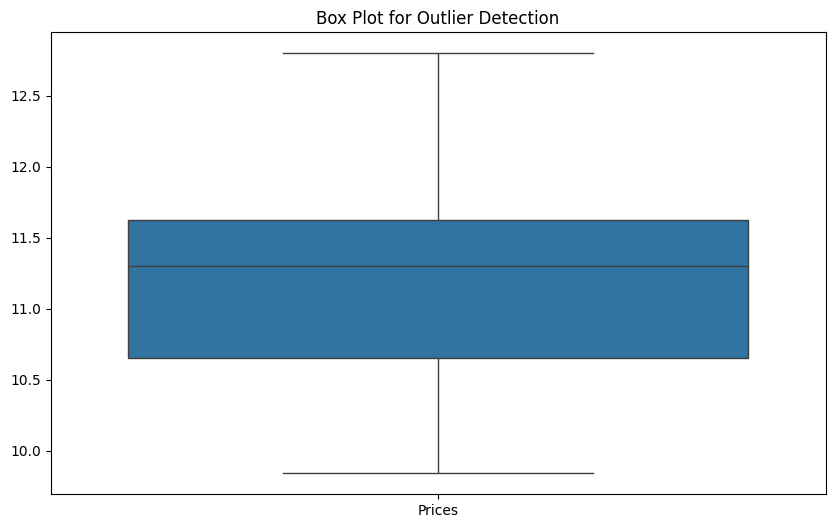

In [6]:
# box plot to check for outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=data)
plt.title('Box Plot for Outlier Detection')
plt.show()

I see that there are no outliers which is good for this

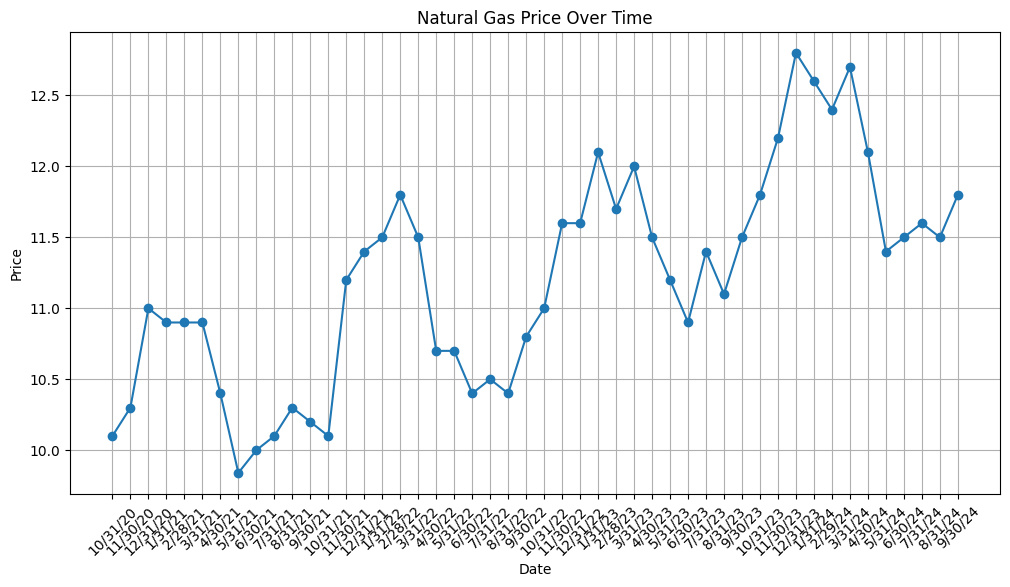

In [8]:
# plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(data['Dates'], data['Prices'], marker='o')
plt.title('Natural Gas Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid()
plt.show()

As expected summers are cheaper than winter.

But I want to take a more granular look and will now divide the data per season and see how seasons affect teh prices

In [ ]:
# Parse the date
data['date_col'] = pd.to_datetime(data['Dates'], format='%m/%d/%y')

# Month name (e.g., "October")
data['Months'] = data['date_col'].dt.month_name()

# Season based on month number
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Fall'
    
# create a new seasson column based on the month number
data['Season'] = data['date_col'].dt.month.map(get_season)

In [15]:
# Sanity check to see the new columns
data.head()

,Dates,Prices,date_col,Months,Season
0,10/31/20,10.1,2020-10-31,October,Fall
1,11/30/20,10.3,2020-11-30,November,Fall
2,12/31/20,11.0,2020-12-31,December,Winter
3,1/31/21,10.9,2021-01-31,January,Winter
4,2/28/21,10.9,2021-02-28,February,Winter


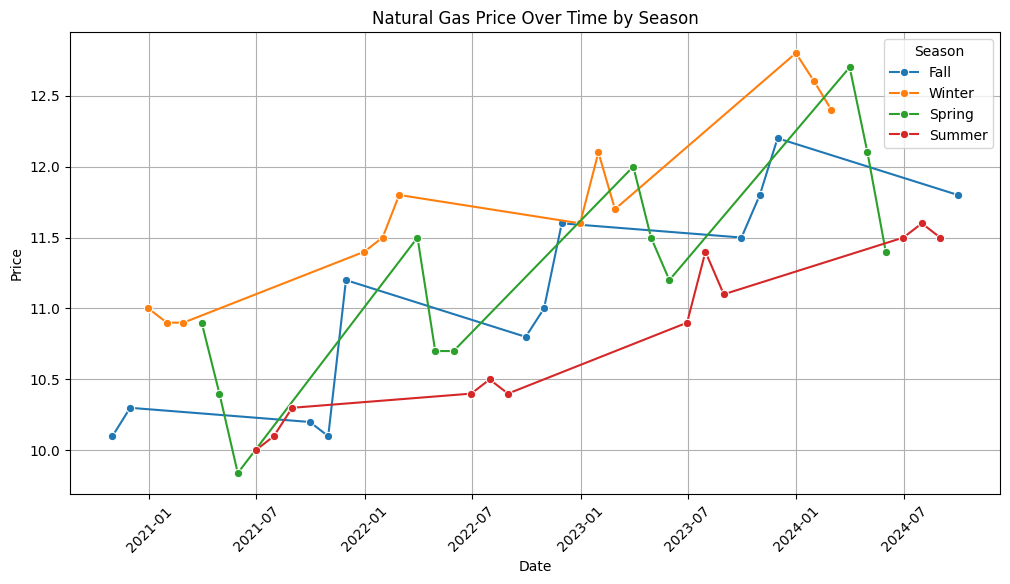

In [14]:
# plot the data by season
plt.figure(figsize=(12, 6))
sns.lineplot(x='date_col', y='Prices', hue='Season', data=data, marker='o')
plt.title('Natural Gas Price Over Time by Season')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid()
plt.legend(title='Season')
plt.show()

As we can see from the plot, there is a clear seasonal pattern in the natural gas prices. The prices tend to be higher during the winter months (December, January, February) and lower during the summer months (June, July, August). This is likely due to increased demand for heating during the winter and decreased demand during the summer. The spring and fall seasons show intermediate price levels.

Yet over all I see a price increase over time, which could be due to various factors such as changes in supply and demand, geopolitical events, or economic conditions. Further analysis would be needed to identify the specific causes of the price trends observed in the data.